In [1]:
import numpy as np
import pandas as pd
from scipy.stats import dirichlet, gamma, uniform, poisson, norm, beta
from scipy.special import comb
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import tqdm
from joblib import Parallel, delayed

from skopt import gp_minimize
from skopt.space import Real
from functools import partial


WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Generation of a c samples

In [2]:
cum_days = np.array([9, 21, 32, 36, 43, 45, 50, 58, 63, 70, 71, 77, 78, 87, 91, 92, 95, 98, 104, 105, 116, 149, 156, 247, 249, 250])
errors = np.arange(len(cum_days)) + 1

Estimated a: 0.2145262940954025, mutiplicative term: 0.2564439232162339
Estimated c: -0.16345729154005484, power term: 0.8365427084599452


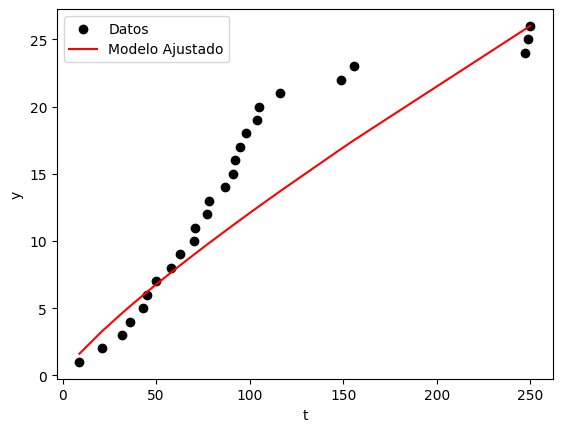

In [3]:
np.random.seed(123)

# Observation period
T = max(cum_days)
n = len(cum_days)

# Define the negative log-likelihood function
def neg_log_likelihood(params):
    a, c = params
    return a * (T**(c+1)) / (c+1) - n * np.log(a) - c * np.sum(np.log(cum_days))  

# Initial guess for parameters
initial_guess = [1.0, 1.0]

# Perform the optimization
result = minimize(neg_log_likelihood, initial_guess, method='L-BFGS-B')

# Extract the estimated parameters
a_est, c_est = result.x

print(f"Estimated a: {a_est}, mutiplicative term: {a_est/(c_est+1)}")
print(f"Estimated c: {c_est}, power term: {c_est+1}")

# Graficar los datos y el modelo ajustado para visualización
plt.scatter(cum_days, errors, label='Datos', color='black')
plt.plot(cum_days, a_est * cum_days ** (1 + c_est) / (1 + c_est), label='Modelo Ajustado', color='red')
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_prima, c_prima]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 106 seconds.


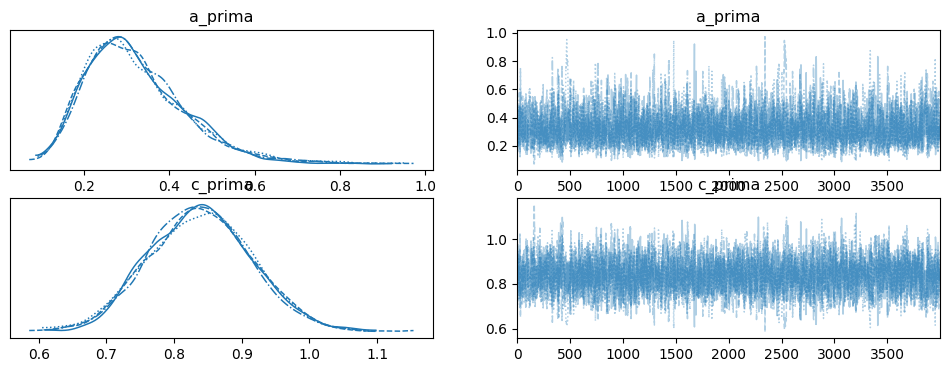

         mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a_prima  0.32  0.12    0.12     0.54        0.0      0.0   2731.43   2928.32   
c_prima  0.84  0.08    0.69     0.98        0.0      0.0   2743.73   2952.25   

         r_hat  
a_prima    1.0  
c_prima    1.0  
Estimación de 'a': 0.322175181222614
Estimación de 'c': 0.8387423907525524


In [5]:
a_prima_est = a_est / (c_est + 1)
c_prima_est = c_est + 1
with pm.Model() as model:    
    a_prima = pm.Gamma('a_prima', alpha=100*a_prima_est**2, beta=100*a_prima_est) 
    c_prima = pm.Gamma('c_prima', alpha=100*c_prima_est**2, beta=100*c_prima_est)
    m_t = a_prima * cum_days ** c_prima

    # a = pm.Exponential('a', lam=a_est)  
    # c = pm.Normal('c', mu=c_est, sigma=0.1)  
    # m_t = a * cum_days ** (c+1)/(c+1)

    observed = pm.Poisson('observed', mu=m_t, observed=errors)
    
    trace = pm.sample(4000, tune=2000, target_accept=0.9, return_inferencedata=True)


# Analizar y visualizar los resultados del muestreo
az.plot_trace(trace)
plt.show()

# Resumen de la distribución posterior
summary = az.summary(trace, round_to=2)
print(summary)

# Extraer los valores medios de 'a' y 'c' de la distribución posterior
a_estimated = trace.posterior["a_prima"].mean().item()
c_estimated = trace.posterior["c_prima"].mean().item()

print("Estimación de 'a':", a_estimated)
print("Estimación de 'c':", c_estimated)

array([[<Axes: >, None],
       [<Axes: xlabel='a_prima', ylabel='c_prima'>, <Axes: >]],
      dtype=object)

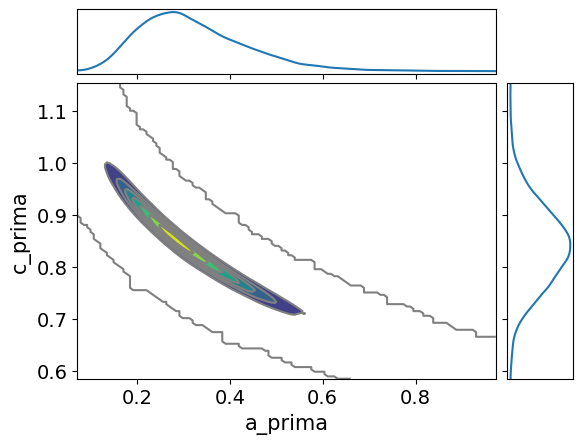

In [59]:
az.plot_pair(trace, divergences=True, kind='kde', marginals=True)

# Auxiliar functions

In [2]:
trace = az.from_netcdf('trace.nc')

In [3]:
def sample_random_ac(trace, num_pairs):
    n_samples = trace.posterior.sizes["draw"]  # Número de muestras
    n_chains = trace.posterior.sizes["chain"]  # Número de cadenas

    # Seleccionar aleatoriamente pares de valores
    random_indices = np.random.choice(n_samples * n_chains, num_pairs)  # Índices aleatorios

    chain_indices = random_indices // n_samples  # Índices de la cadena
    draw_indices = random_indices % n_samples  # Índices de la muestra dentro de la cadena

    # Extraer valores de la cadena posterior usando indexación avanzada
    a_values = trace.posterior["a_prima"].values[chain_indices, draw_indices]
    c_values = trace.posterior["c_prima"].values[chain_indices, draw_indices]

    # Combinar los valores a y c en pares
    random_ac = np.column_stack((a_values, c_values))
    return random_ac

In [4]:
def utility_func(x, rho1):
    if rho1 is None: 
        return x
    return (1 - np.exp(-rho1 * x)) / rho1

# Simple case

In [5]:
def compute_expected_utility_vec_random_ac(t1, p1, c11, c21, c31, n, T, ite=5000, rho1=None, fact=100):    
    # Generating random variables for j=2,3
    ts = uniform.rvs(loc=0, scale=2000, size=(ite, 2))
    ps = uniform.rvs(loc=3000, scale=12000, size=(ite, 2))
    aes = gamma.rvs(.256**2/.2**2, scale=.2**2/.256, size=(ite, 2))  # so it has mean .256 and variance .04
    mean = .837
    std = .2
    cs = beta.rvs(mean*(mean*(1-mean)/std**2-1), (1-mean)*(mean*(1-mean)/std**2-1), size=(ite, 2))
    lambda23Tt = aes * (T ** cs - ts ** cs)
    qs = poisson.rvs(lambda23Tt) 

    # Generating buyer random variables
    w = dirichlet.rvs([1, 1, 1], size=ite)
    rho = gamma.rvs(10, scale=1/10, size=ite)

    # Generating random variables for j=1
    acs = sample_random_ac(trace, ite)
    lambda1_t1 = acs[:, 0] * t1 ** acs[:, 1]
    lambda1_T = acs[:, 0] * T ** acs[:, 1]
    lambda1_Tt = acs[:, 0] * (T ** acs[:, 1] - t1 ** acs[:, 1])
    e1 = poisson.rvs(lambda1_t1, size=ite)
    eT = poisson.rvs(lambda1_T, size=ite)
    q1 = poisson.rvs(lambda1_Tt, size=ite)

    # Computing utility
    u1 = 1 - np.exp(-rho * (-w[:, 0] * t1 / T - w[:, 1] * p1 / 5000 - w[:, 2] * q1 / eT))
    u2 = 1 - np.exp(-rho * (-w[:, 0] * ts[:, 0] / T - w[:, 1] * ps[:, 0] / 5000 - w[:, 2] * qs[:, 0] / eT)) - u1
    u3 = 1 - np.exp(-rho * (-w[:, 0] * ts[:, 1] / T - w[:, 1] * ps[:, 1] / 5000 - w[:, 2] * qs[:, 1] / eT)) - u1

    # Computing probability of choice
    pi = (1 / (1 + np.exp(u2) + np.exp(u3))).mean()
    # Estimating the cost
    c1 = fact * (c11 * t1 + c21 * e1 + c31 * q1).mean()

    # Estimating expected utility
    util = np.sum([comb(n, l) * pi**l * (1 - pi)**(n - l) * utility_func(l * p1 - c1, rho1) for l in range(n+1)])
    
    profit = np.sum([comb(n, l) * pi**l * (1 - pi)**(n - l) * (l * p1 - c1) for l in range(n+1)])
    
    return util, pi, profit

In [25]:
c11 = 0.5
c21 = 1
c31 = 5
n = 1000
T = 2000

resultados = np.zeros((100 * 100, 4))
indice = 0
for p1 in np.linspace(3000, 15000, 100):
    for t1 in np.linspace(0, 2000, 100):
        util, prob = compute_expected_utility_vec_random_ac(t1, p1, c11, c21, c31, n, T, ite=10000)
        resultados[indice] = [p1, t1, util, prob]
        indice += 1

indice_mejor = np.argmax(resultados[:, 2])
mejor_datos = resultados[indice_mejor, :2]
mejor_util = resultados[indice_mejor, 2]
mejor_prob = resultados[indice_mejor, 3]

print("Mejores datos:", mejor_datos, "Mejor utilidad:", mejor_util, "Mejor probabilidad:", mejor_prob)
np.save('resultados.npy', resultados)

C:\Users\pgarc\AppData\Local\Temp\ipykernel_1896\3415444743.py:32: RuntimeWarning: overflow encountered in exp
  pi = (1 / (1 + np.exp(u2) + np.exp(u3))).mean()


Mejores datos: [10151.51515152   929.29292929] Mejor utilidad: 3464304.466521217 Mejor probabilidad: 0.3413558245900615


In [26]:
c11 = 0.5
c21 = 1
c31 = 5
n = 1000
T = 2000

resultados = np.zeros((50 * 50, 4)) 
indice = 0
for p1 in np.linspace(9500, 11000, 50):
    for t1 in np.linspace(500, 1000, 50):
        util, prob = compute_expected_utility_vec_random_ac(t1, p1, c11, c21, c31, n, T, ite=10000)
        resultados[indice] = [p1, t1, util, prob]
        indice += 1

indice_mejor = np.argmax(resultados[:, 2])
mejor_datos = resultados[indice_mejor, :2]
mejor_util = resultados[indice_mejor, 2]
mejor_prob = resultados[indice_mejor, 3]

print("Mejores datos:", mejor_datos, "Mejor utilidad:", mejor_util, "Mejor probabilidad:", mejor_prob)
np.save('resultados_resolucion.npy', resultados)

C:\Users\pgarc\AppData\Local\Temp\ipykernel_1896\3415444743.py:32: RuntimeWarning: overflow encountered in exp
  pi = (1 / (1 + np.exp(u2) + np.exp(u3))).mean()


Mejores datos: [10234.69387755   551.02040816] Mejor utilidad: 3485064.531083048 Mejor probabilidad: 0.34060415979139613


In [14]:
resultados = np.load('resultados_resolucion.npy')

In [8]:
indice_mejor = np.argmax(resultados[:, 2])
mejor_datos = resultados[indice_mejor, :2]
mejor_util = resultados[indice_mejor, 2]
mejor_prob = resultados[indice_mejor, 3]

print("Mejores datos:", mejor_datos, "Mejor utilidad:", mejor_util, "Mejor probabilidad:", mejor_prob)

Mejores datos: [9787.87878788  484.84848485] Mejor utilidad: 3109929.7853285507 Mejor probabilidad: 0.3274993481876013


In [15]:
mejores_precios = []
for i in range(50):
    seleccion = resultados[abs(resultados[:, 1] - np.linspace(0, 2000, 50)[i]) < 1e-1]    
    mejores_precios.append(seleccion[np.argmax(seleccion[:, 2]), 0])

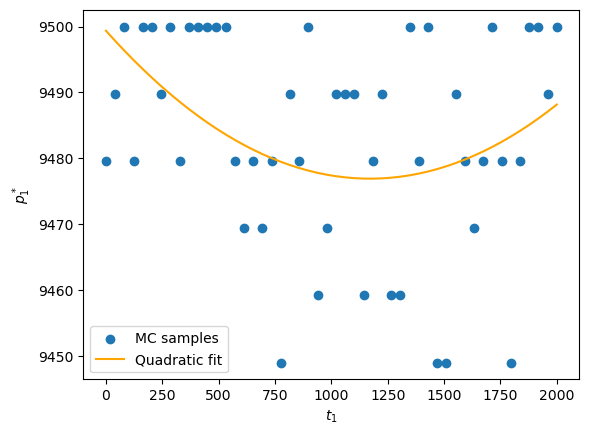

In [16]:
xs = np.linspace(0, 2000, 50)
c, b, a = np.polyfit(xs, mejores_precios, 2)
ys = a + b * xs + c * xs ** 2

plt.scatter(xs, mejores_precios)
plt.plot(xs, ys, color='orange')
plt.xlabel('$t_1$')
plt.ylabel('$p^*_1$')
plt.legend(['MC samples', 'Quadratic fit'])

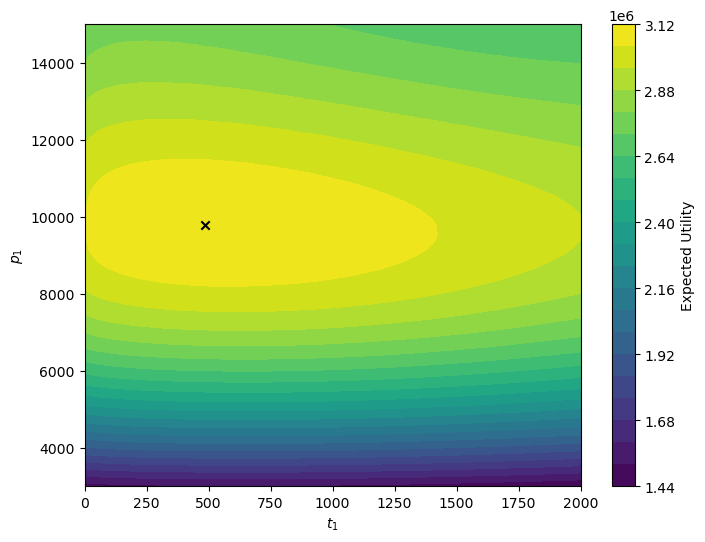

In [9]:
p1_vals = resultados[:, 0]
t1_vals = resultados[:, 1]
util_vals = resultados[:, 2]

p1_unique = np.unique(p1_vals)
t1_unique = np.unique(t1_vals)
util_matrix = util_vals.reshape(len(p1_unique), len(t1_unique))

plt.figure(figsize=(8, 6))
contourf = plt.contourf(t1_unique, p1_unique, util_matrix, levels=20, cmap='viridis')
plt.colorbar(contourf, label='Expected Utility')
plt.scatter(mejor_datos[1], mejor_datos[0], marker='x', c='black')
plt.xlabel('$t_1$')
plt.ylabel('$p_1$')
plt.show()

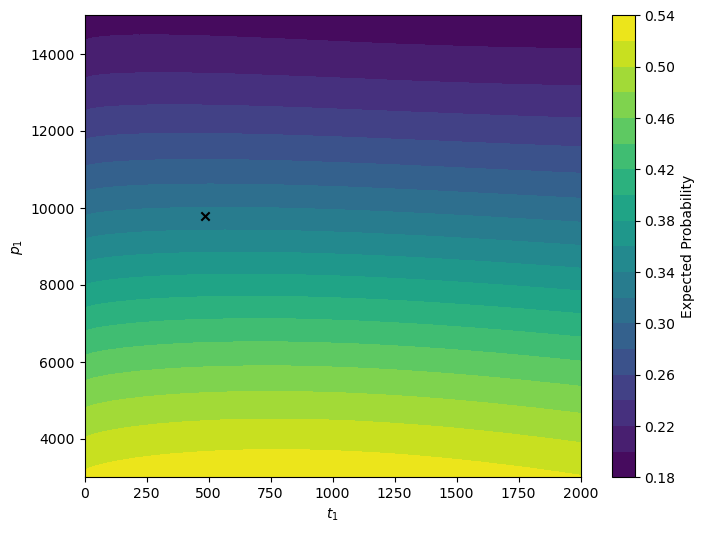

In [10]:
p1_vals = resultados[:, 0]
t1_vals = resultados[:, 1]
prob_vals = resultados[:, 3]

p1_unique = np.unique(p1_vals)
t1_unique = np.unique(t1_vals)
prob_matrix = prob_vals.reshape(len(p1_unique), len(t1_unique))

plt.figure(figsize=(8, 6))
contourf = plt.contourf(t1_unique, p1_unique, prob_matrix, levels=20, cmap='viridis')
plt.colorbar(contourf, label='Expected Probability')
plt.scatter(mejor_datos[1], mejor_datos[0], marker='x', c='black')
plt.xlabel('$t_1$')
plt.ylabel('$p_1$')
plt.show()

100%|██████████| 50/50 [01:20<00:00,  1.60s/it]


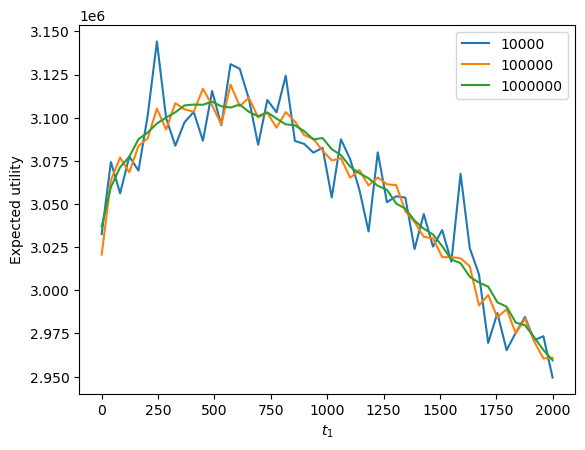

In [7]:
c11 = 0.5
c21 = 1
c31 = 5
n = 1000
T = 2000

utils = []
utils_vec = []
utils_est = []
p1 = 9787.87878788
for t1 in tqdm.tqdm(np.linspace(0, 2000, 50)):
    utils.append(compute_expected_utility_vec_random_ac(t1, p1, c11, c21, c31, n, T, ite=10000))
    utils_vec.append(compute_expected_utility_vec_random_ac(t1, p1, c11, c21, c31, n, T, ite=100000))
    utils_est.append(compute_expected_utility_vec_random_ac(t1, p1, c11, c21, c31, n, T, ite=1000000))

plt.plot(np.linspace(0, 2000, 50), [u[0] for u in utils])
plt.plot(np.linspace(0, 2000, 50), [u[0] for u in utils_vec])
plt.plot(np.linspace(0, 2000, 50), [u[0] for u in utils_est])
plt.xlabel('$t_1$')
plt.ylabel('Expected utility')
plt.legend([10000, 100000, 1000000])

In [20]:
c11 = 0.5
c21 = 1
c31 = 5
n = 1000
T = 2000

resultados = np.zeros((7 * 20 * 20, 6)) 
indice = 0

rhos = [-1e-6, -1e-7, -1e-8, None, 1e-8, 1e-7, 1e-6]
for rho1 in rhos:
    print(rho1)
    for p1 in np.linspace(9500, 12000, 20):
        for t1 in np.linspace(500, 1000, 20):
            util, prob, profit = compute_expected_utility_vec_random_ac(t1, p1, c11, c21, c31, n, T, ite=10000, rho1=rho1)
            resultados[indice] = [p1, t1, util, prob, profit, rho1]
            indice += 1
np.save('resultados_rhos.npy', resultados)

-1e-06


NameError: name 'compute_expected_utility_vec_random_ac' is not defined

In [18]:
resultados_rho = np.load('resultados_rho.npy', allow_pickle=True)

rhos = [None, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]
for rho in rhos:
    if rho is None:
        seleccion = resultados_rho[[r is None for r in resultados_rho[:, 5]]]   
    else:
        seleccion = resultados_rho[resultados_rho[:, 5] == rho]    
    
    indice_mejor = np.argmax(seleccion[:, 2])
    mejor_datos = seleccion[indice_mejor, :2]
    mejor_util = seleccion[indice_mejor, 2]
    mejor_prob = seleccion[indice_mejor, 3]
    mejor_profit = seleccion[indice_mejor, 4]

    print(f"Rho: {rho}, p_1: {mejor_datos[0]:.0f}, t_1: {mejor_datos[1]:.0f}, Expected utility: {mejor_util:.0f}, Profit: {mejor_profit:.0f}, Probability: {mejor_prob:.2f}")

Rho: None, p_1: 9735, t_1: 490, Expected utility: 3110284, Profit: 3110284, Probability: 0.33
Rho: 1e-08, p_1: 9755, t_1: 502, Expected utility: 3062343, Profit: 3110318, Probability: 0.33
Rho: 1e-07, p_1: 9776, t_1: 511, Expected utility: 2672398, Profit: 3110421, Probability: 0.33
Rho: 1e-06, p_1: 9633, t_1: 487, Expected utility: 954954, Profit: 3110371, Probability: 0.33
Rho: 1e-05, p_1: 9122, t_1: 579, Expected utility: 100000, Profit: 3100294, Probability: 0.35
Rho: 0.0001, p_1: 9061, t_1: 484, Expected utility: 10000, Profit: 3097595, Probability: 0.35


In [19]:
resultados_c31 = np.load('resultados_c31.npy', allow_pickle=True)

c31s = np.linspace(1, 40, 40)
df_resultados = pd.DataFrame(columns=['c31', 'p1', 't1', 'util', 'prob'])
for c31 in c31s:
    seleccion = resultados_c31[resultados_c31[:, 4] == c31]    
    indice_mejor = np.argmax(seleccion[:, 2])
    mejor_datos = seleccion[indice_mejor, :2]
    mejor_util = seleccion[indice_mejor, 2]
    mejor_prob = seleccion[indice_mejor, 3]

    new_row = pd.DataFrame([{'c31': c31, 'p1': mejor_datos[0], 't1': mejor_datos[1], 'util': mejor_util, 'prob': mejor_prob}])
    df_resultados = pd.concat([df_resultados, new_row], ignore_index=True)

C:\Users\pgarc\AppData\Local\Temp\ipykernel_16704\516916922.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_resultados = pd.concat([df_resultados, new_row], ignore_index=True)


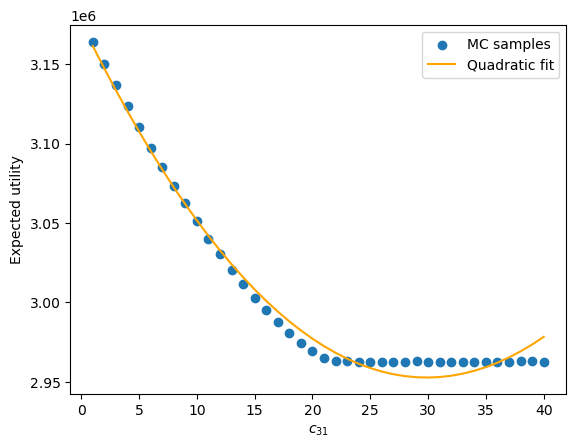

In [20]:
# plot of the expected utility as a function of c31
plt.scatter(df_resultados['c31'], df_resultados['util'])
c, b, a = np.polyfit(df_resultados['c31'], df_resultados['util'], 2)
var_fit = a + b * df_resultados['c31'] + c * df_resultados['c31'] ** 2
plt.plot(df_resultados['c31'], var_fit, color='orange')
plt.xlabel('$c_{31}$')
plt.ylabel('Expected utility')
plt.legend(['MC samples', 'Quadratic fit'])

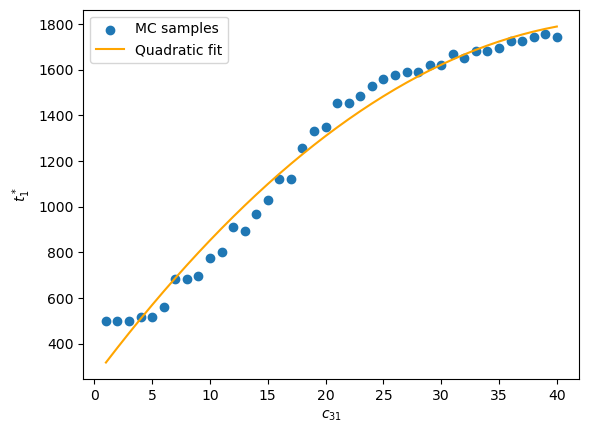

In [9]:
# plot of the optimal t1 as a function of c31
plt.scatter(df_resultados['c31'], df_resultados['t1'])
c, b, a = np.polyfit(df_resultados['c31'], df_resultados['t1'], 2)
var_fit = a + b * df_resultados['c31'] + c * df_resultados['c31'] ** 2
plt.plot(df_resultados['c31'], var_fit, color='orange')
plt.xlabel('$c_{31}$')
plt.ylabel('$t_1^*$')
plt.legend(['MC samples', 'Quadratic fit'])

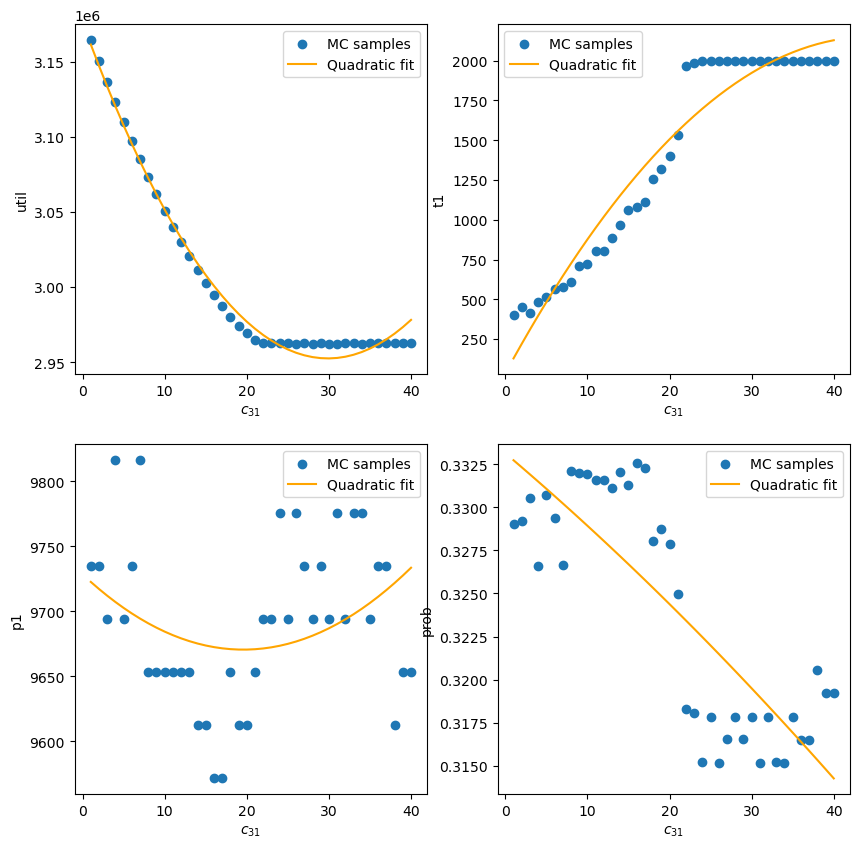

In [21]:
# do 4 subplots for util, t1, c1 and prob in a same figure
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for var in ['util', 't1', 'p1', 'prob']:
    ax = axs.flatten()[['util', 't1', 'p1', 'prob'].index(var)]
    ax.scatter(df_resultados['c31'], df_resultados[var])
    c, b, a = np.polyfit(df_resultados['c31'], df_resultados[var], 2)
    var_fit = a + b * df_resultados['c31'] + c * df_resultados['c31'] ** 2
    ax.plot(df_resultados['c31'], var_fit, color='orange')
    ax.set_xlabel('$c_{31}$')
    ax.set_ylabel(var)
    ax.legend(['MC samples', 'Quadratic fit'])

In [17]:
# Define the parameter space
space = [Real(3000, 15000, name='p1'), Real(0, 2000, name='t1')]
    
c11 = 0.5
c21 = 1
c31 = 5
n = 1000  
T = 2000

# Define the objective function wrapper for skopt
def objective_function(params, c11, c21, c31, n, T):
    p1, t1 = params
    return -compute_expected_utility_vec_random_ac(t1, p1, c11, c21, c31, n, T, ite=100000)[0]

# Define partial function for passing extra parameters to the objective function
objective_function_partial = partial(objective_function, c11=c11, c21=c21, c31=c31, n=n, T=T)

# Perform Bayesian optimization
result = gp_minimize(objective_function_partial, space, n_calls=200, n_jobs=-1)

# Get the optimal parameters
p1_optimal_gp, t1_optimal_gp = result.x
optimal_utility_gp = -result.fun

print("Optimal p1:", p1_optimal_gp)
print("Optimal t1:", t1_optimal_gp)
print("Optimal utility:", optimal_utility_gp)

Optimal p1: 9178.179675683508
Optimal t1: 611.2904721651753
Optimal utility: 2869575.973550805


In [18]:
c11 = 0.5
c21 = 1
c31 = 5
n = 1000  
T = 2000

def generate_neighbor(t1, p1):
    # Generate a neighboring solution by perturbing t1 and p1 within a certain range
    new_t1 = np.clip(t1 + np.random.uniform(-50, 50), 0, 2000)
    new_p1 = np.clip(p1 + np.random.uniform(-200, 200), 3000, 15000)
    return new_t1, new_p1

def simulated_annealing(initial_t1, initial_p1, c11, c21, c31, n, T, max_iter=1000):
    # Set initial temperature and cooling rate
    temperature = 1000
    cooling_rate = 0.99

    # Initialize current solution
    current_t1, current_p1 = initial_t1, initial_p1
    current_util = compute_expected_utility_vec_random_ac(current_t1, current_p1, c11, c21, c31, n, T, ite=500000)[0]

    # Initialize best solution
    best_t1, best_p1 = current_t1, current_p1
    best_util = current_util

    # Simulated Annealing algorithm
    for _ in tqdm.tqdm(range(max_iter)):
        # Generate a neighboring solution
        new_t1, new_p1 = generate_neighbor(current_t1, current_p1)

        # Calculate the cost of the new solution
        new_util = compute_expected_utility_vec_random_ac(new_t1, new_p1, c11, c21, c31, n, T, ite=500000)[0]

        # Calculate the acceptance probability
        delta_util = new_util - current_util
        acceptance_probability = np.exp(delta_util / temperature)

        # Accept or reject the new solution
        if np.random.uniform() < acceptance_probability:
            current_t1, current_p1 = new_t1, new_p1
            current_util = new_util

        # Update the best solution
        if current_util > best_util:
            best_t1, best_p1 = current_t1, current_p1
            best_util = current_util

        # Cool down the temperature
        temperature *= cooling_rate

    return best_t1, best_p1

# Example usage
initial_t1 = np.random.uniform(0, 2000)
initial_p1 = np.random.uniform(3000, 15000)
t1_optimal_sa, p1_optimal_sa = simulated_annealing(initial_t1, initial_p1, c11, c21, c31, n, T)
print("Best t_1:", t1_optimal_sa)
print("Best p_1:", p1_optimal_sa)

C:\Users\pgarc\AppData\Local\Temp\ipykernel_19236\3472501846.py:30: RuntimeWarning: overflow encountered in exp
  pi = (1 / (1 + np.exp(u2) + np.exp(u3))).mean()
100%|██████████| 1000/1000 [09:42<00:00,  1.72it/s]

Best t_1: 484.20049715496856
Best p_1: 9230.276117599064


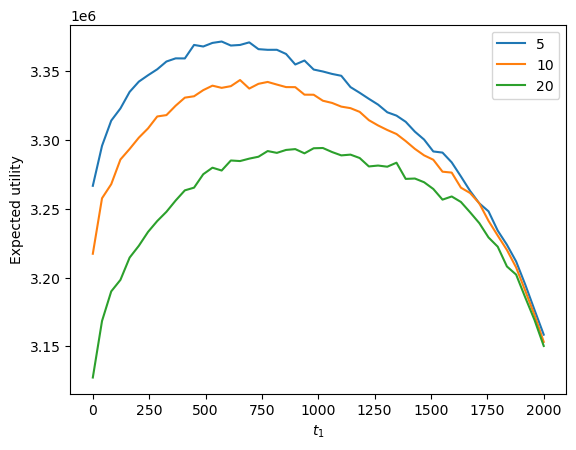

In [35]:
c11 = 0.5
c21 = 1
c31 = 5
n = 1000
T = 2000

utils = []
utils_vec = []
utils_est = []
p1 = 10151.51515152
f = 50
for t1 in np.linspace(0, 2000, 50):
    utils.append(compute_expected_utility_vec_random_ac(t1, p1, c11, c21, c31, n, T, ite=1000000, fact=f))
    utils_vec.append(compute_expected_utility_vec_random_ac(t1, p1, c11, c21, 10, n, T, ite=1000000, fact=f))
    utils_est.append(compute_expected_utility_vec_random_ac(t1, p1, c11, c21, 20, n, T, ite=1000000, fact=f))

plt.plot(np.linspace(0, 2000, 50), [u[0] for u in utils])
plt.plot(np.linspace(0, 2000, 50), [u[0] for u in utils_vec])
plt.plot(np.linspace(0, 2000, 50), [u[0] for u in utils_est])
plt.xlabel('$t_1$')
plt.ylabel('Expected utility')
plt.legend([5, 10, 20])

In [32]:
c11 = 0.5
c21 = 1
c31 = 5
n = 1000
T = 2000

# Example usage
t1 = mejor_datos[1]
p1 = mejor_datos[0]  
random_ac = []
for i in range(10):
    util, _, _ = compute_expected_utility_vec_random_ac(t1, p1, c11, c21, c31, n, T, ite=100000)
    random_ac.append(util)
print(f'Brute force: {p1:.0f}, {t1:.0f}, {np.array(random_ac).mean():.0f}')


t1 = t1_optimal_gp
p1 = p1_optimal_gp
random_ac = []
for i in range(10):
    util, _, _ = compute_expected_utility_vec_random_ac(t1, p1, c11, c21, c31, n, T, ite=100000)
    random_ac.append(util)

print(f'Bayesian optimization: {p1:.0f}, {t1:.0f}, {np.array(random_ac).mean():.0f}')


t1 = t1_optimal_sa
p1 = p1_optimal_sa
random_ac = []
for i in range(10):
    util, _, _ = compute_expected_utility_vec_random_ac(t1, p1, c11, c21, c31, n, T, ite=100000)
    random_ac.append(util)

print(f'Simulated annealing: {p1:.0f}, {t1:.0f}, {np.array(random_ac).mean():.0f}')

Brute force: 9286, 531, 2854205
Bayesian optimization: 9178, 611, 2851768
Simulated annealing: 9230, 484, 2852565


# Purchase of multiple items

In [25]:
def knapsack_solver(utilities, prices, budgets):
    # Generar todos los subconjuntos posibles una vez
    subsets = [[0], [1], [0, 1], [2], [0, 2], [1, 2], [0, 1, 2]]

    # Inicializar la cantidad total de ventas
    total_sells = 0

    # Precalcular las sumas de precios y utilidades para cada subconjunto
    prices_sums = np.array([prices[subset, :].sum(axis=0) for subset in subsets])
    utilities_sums = np.array([utilities[subset, :].sum(axis=0) for subset in subsets])

    # Iterar sobre cada presupuesto
    for budget in budgets:
        mask = prices_sums <= budget
        utilities_masked = np.where(mask, utilities_sums, -1000)
        indices = np.argmax(utilities_masked, axis=0)

        # Contar las ventas de productos cuyos índices son pares
        total_sells += (indices % 2 == 0).sum()

    return total_sells

In [26]:
def compute_expected_utility_multiple_items(t1, p1, c11, c21, c31, n, T, ite=5000, rho1=None, fact=100):
    # Generating random variables for j=2,3
    ts = uniform.rvs(loc=0, scale=2000, size=(ite, 2))
    ps = uniform.rvs(loc=3000, scale=12000, size=(ite, 2))
    aes = gamma.rvs(.256**2/.2**2, scale=.2**2/.256, size=(ite, 2))  # so it has mean .256 and variance .04
    mean = .837
    std = .2
    cs = beta.rvs(mean*(mean*(1-mean)/std**2-1), (1-mean)*(mean*(1-mean)/std**2-1), size=(ite, 2))
    lambda23Tt = aes * (T ** cs - ts ** cs)
    qs = poisson.rvs(lambda23Tt)

    # Generating buyer random variables
    w = dirichlet.rvs([1, 1, 1], size=ite)
    rho = gamma.rvs(10, scale=1/10, size=ite)

    # Generating random variables for j=1
    acs = sample_random_ac(trace, ite)
    lambda1_t1 = acs[:, 0] * t1 ** acs[:, 1]
    lambda1_T = acs[:, 0] * T ** acs[:, 1]
    lambda1_Tt = acs[:, 0] * (T ** acs[:, 1] - t1 ** acs[:, 1])
    e1 = poisson.rvs(lambda1_t1, size=ite)
    eT = poisson.rvs(lambda1_T, size=ite)
    q1 = poisson.rvs(lambda1_Tt, size=ite)

    # Computing utility
    u1 = 1 - np.exp(-rho * (-w[:, 0] * t1 / T - w[:, 1] * p1 / 5000 - w[:, 2] * q1 / eT))
    u2 = 1 - np.exp(-rho * (-w[:, 0] * ts[:, 0] / T - w[:, 1] * ps[:, 0] / 5000 - w[:, 2] * qs[:, 0] / eT))
    u3 = 1 - np.exp(-rho * (-w[:, 0] * ts[:, 1] / T - w[:, 1] * ps[:, 1] / 5000 - w[:, 2] * qs[:, 1] / eT))

    # Estimating the cost
    c1 = fact * (c11 * t1 + c21 * e1 + c31 * q1).mean()

    # Solving the knapsack problem for each buyer
    budgets = np.random.uniform(10000, 20000, (n, ite))

    total_sales = knapsack_solver(
            np.array([u1, u2, u3]), 
            np.array([p1*np.ones([ps.shape[0]]), ps[:, 0], ps[:, 1]]),
            np.array(budgets))

    # Expected utility
    s = total_sales / ite
    util = utility_func(s * p1 - c1, rho1)
    
    profit = s * p1 - c1
    
    return util, profit

In [27]:
c11 = 0.5
c21 = 1
c31 = 5
n = 1000
T = 2000

p1 = 9000.51515152
t1 = 606.06060606

compute_expected_utility_multiple_items(t1, p1, c11, c21, c31, n, T, ite=1000000)

(2495301.660470527, 2495301.660470527)

Mejores datos: [6757.57575758   80.80808081] Mejor utilidad: 3027192.9324444444


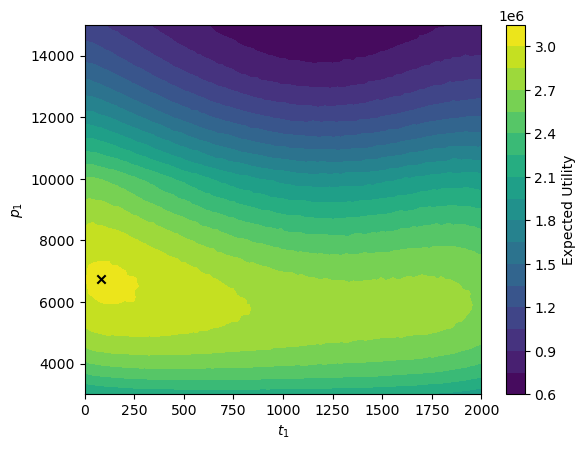

In [33]:
resultados = np.load('resultados_multiple_items.npy')

indice_mejor = np.argmax(resultados[:, 2])
mejor_datos = resultados[indice_mejor, :2]
mejor_util = resultados[indice_mejor, 2]

print("Mejores datos:", mejor_datos, "Mejor utilidad:", mejor_util)


p1_vals = resultados[:, 0]
t1_vals = resultados[:, 1]
util_vals = resultados[:, 2]

p1_unique = np.unique(p1_vals)
t1_unique = np.unique(t1_vals)
util_matrix = util_vals.reshape(len(p1_unique), len(t1_unique))

contourf = plt.contourf(t1_unique, p1_unique, util_matrix, levels=20, cmap='viridis')
plt.colorbar(contourf, label='Expected Utility')
plt.scatter(mejor_datos[1], mejor_datos[0], marker='x', c='black')
plt.xlabel('$t_1$')
plt.ylabel('$p_1$')
plt.show()

Text(0, 0.5, 'Expected utility')

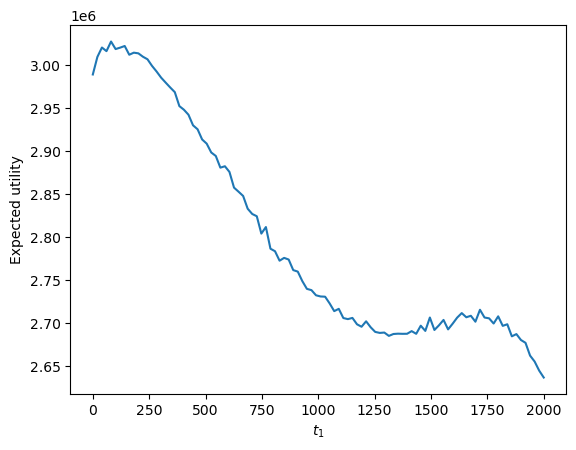

In [35]:
slice_p1 = resultados[resultados[:, 0] == mejor_datos[0]]
plt.plot(slice_p1[:, 1], slice_p1[:, 2])
plt.xlabel('$t_1$')
plt.ylabel('Expected utility')

# Inteligent competitors

In [17]:
def compute_expected_utility_inteligent_competitors(ts, ps, c11, c21, c31, n, T, ite=5000, rho1=None, fact=100):   
    aes = gamma.rvs(.256**2/.2**2, scale=.2**2/.256, size=(ite, 2))  # so it has mean .256 and variance .04
    mean = .837
    std = .2
    cs = beta.rvs(mean*(mean*(1-mean)/std**2-1), (1-mean)*(mean*(1-mean)/std**2-1), size=(ite, 2))
    lambda23Tt = aes * (T ** cs - ts[1:] ** cs)
    qs = poisson.rvs(lambda23Tt)

    # Generating buyer random variables
    w = dirichlet.rvs([1, 1, 1], size=ite)
    rho = gamma.rvs(10, scale=1/10, size=ite)

    # Generating random variables for j=1
    acs = sample_random_ac(trace, ite)
    lambda1_t1 = acs[:, 0] * ts[0] ** acs[:, 1]
    lambda1_T = acs[:, 0] * T ** acs[:, 1]
    lambda1_Tt = acs[:, 0] * (T ** acs[:, 1] - ts[0] ** acs[:, 1])
    e1 = poisson.rvs(lambda1_t1, size=ite)
    eT = poisson.rvs(lambda1_T, size=ite)
    q1 = poisson.rvs(lambda1_Tt, size=ite)

    # Computing utility
    u1 = 1 - np.exp(-rho * (-w[:, 0] * ts[0] / T - w[:, 1] * ps[0] / 5000 - w[:, 2] * q1 / eT))
    u2 = 1 - np.exp(-rho * (-w[:, 0] * ts[1] / T - w[:, 1] * ps[1] / 5000 - w[:, 2] * qs[:, 0] / eT))
    u3 = 1 - np.exp(-rho * (-w[:, 0] * ts[2] / T - w[:, 1] * ps[2] / 5000 - w[:, 2] * qs[:, 1] / eT))

    # Computing probability of choice
    pi1 = (1 / (1 + np.exp(u2-u1) + np.exp(u3-u1))).mean()
    pi2 = (1 / (1 + np.exp(u1-u2) + np.exp(u3-u2))).mean()
    pi3 = (1 / (1 + np.exp(u1-u3) + np.exp(u2-u3))).mean()
    # Estimating the cost
    c1 = fact * (c11 * ts[0] + c21 * e1 + c31 * q1).mean()
    c2 = fact * (c11 * ts[1] + c21 * e1 + c31 * qs[:, 0]).mean()
    c3 = fact * (c11 * ts[2] + c21 * e1 + c31 * qs[:, 1]).mean()

    # Estimating expected utility
    util1 = np.sum([comb(n, l) * pi1**l * (1 - pi1)**(n - l) * utility_func(l * ps[0] - c1, rho1) for l in range(n+1)])
    util2 = np.sum([comb(n, l) * pi2**l * (1 - pi2)**(n - l) * utility_func(l * ps[1] - c2, rho1) for l in range(n+1)])
    util3 = np.sum([comb(n, l) * pi3**l * (1 - pi3)**(n - l) * utility_func(l * ps[2] - c3, rho1) for l in range(n+1)])
    
    return np.array([util1, util2, util3])

In [20]:
c11 = 0.5
c21 = 1
c31 = 5
n = 1000
T = 2000

# We begin optimizing p1 and t1 for random p2, t2, p3 and t3 and then optimize the rest and then again p1 and t1 for those values
# Define the parameter space
space = [Real(3000, 15000, name='p1'), Real(0, 2000, name='t1')]

# Define the objective function wrapper for skopt

def objective_function(params, c11, c21, c31, n, T, p2, t2, p3, t3):
    p1, t1 = params
    ts = np.array([t1, t2, t3])
    ps = np.array([p1, p2, p3])
    return -compute_expected_utility_inteligent_competitors(ts, ps, c11, c21, c31, n, T, ite=100000)[0]

# Define partial function for passing extra parameters to the objective function
objective_function_partial = partial(objective_function, c11=c11, c21=c21, c31=c31, n=n, T=T, p2=10000, t2=500, p3=10000, t3=500)

# Perform Bayesian optimization
result = gp_minimize(objective_function_partial, space, n_calls=200)

# Get the optimal parameters
p1_optimal, t1_optimal = result.x
optimal_utility = -result.fun

print("Optimal p1:", p1_optimal)
print("Optimal t1:", t1_optimal)
print("Optimal utility:", optimal_utility)

# Define the parameter space
space = [Real(3000, 15000, name='p2'), Real(0, 2000, name='t2'),
         Real(3000, 15000, name='p3'), Real(0, 2000, name='t3')]

# Define the objective function wrapper for skopt
def objective_function(params, c11, c21, c31, n, T, p1, t1):
    p2, t2, p3, t3 = params
    ts = np.array([t1, t2, t3])
    ps = np.array([p1, p2, p3])
    return -compute_expected_utility_inteligent_competitors(ts, ps, c11, c21, c31, n, T, ite=100000)[1:].sum()

# Define partial function for passing extra parameters to the objective function
objective_function_partial = partial(objective_function, c11=c11, c21=c21, c31=c31, n=n, T=T, p1=p1_optimal, t1=t1_optimal)

# Perform Bayesian optimization
result = gp_minimize(objective_function_partial, space, n_calls=200)

# Get the optimal parameters
p2_optimal, t2_optimal, p3_optimal, t3_optimal = result.x
optimal_utility = -result.fun

print("Optimal p2:", p2_optimal)
print("Optimal t2:", t2_optimal)
print("Optimal p3:", p3_optimal)
print("Optimal t3:", t3_optimal)
print("Optimal utility:", optimal_utility)

# Define the parameter space
space = [Real(3000, 15000, name='p1'), Real(0, 2000, name='t1')]

# Define the objective function wrapper for skopt
def objective_function(params, c11, c21, c31, n, T, p2, t2, p3, t3):
    p1, t1 = params
    ts = np.array([t1, t2, t3])
    ps = np.array([p1, p2, p3])
    return -compute_expected_utility_inteligent_competitors(ts, ps, c11, c21, c31, n, T, ite=100000)[0]

# Define partial function for passing extra parameters to the objective function
objective_function_partial = partial(objective_function, c11=c11, c21=c21, c31=c31, n=n, T=T, p2=p2_optimal, t2=t2_optimal, p3=p3_optimal, t3=t3_optimal)

# Perform Bayesian optimization
result = gp_minimize(objective_function_partial, space, n_calls=200)

# Get the optimal parameters
p1_optimal, t1_optimal = result.x
optimal_utility = -result.fun

print("Optimal p1:", p1_optimal)
print("Optimal t1:", t1_optimal)
print("Optimal utility:", optimal_utility)

Optimal p1: 8568.253278947635
Optimal t1: 720.1027491587832
Optimal utility: 3415587.3041753788
Optimal p2: 15000.0
Optimal t2: 0.0
Optimal p3: 8554.696883948607
Optimal t3: 1253.111232209174
Optimal utility: 5963770.912882317
Optimal p1: 8165.915982739285
Optimal t1: 796.2404319507784
Optimal utility: 3462343.6478861934
